# Aprendizado Não-Supervisionado

## Exercício 01 - Clusterização de Documentos

Nesse exercício vamos utilizar os métodos de clusterização estudados para agrupar documentos. Neste exemplo, documentos serão compostos pelas sinópses de filmes. Vamos seguir a proposto [deste tuturial](http://brandonrose.org/clustering). Para construir a base de dados, coletamos as sinopses dos 100 filmes mais bem votados do IMDb. Para isso, utilizamos a API do [imdbpie](https://github.com/richardasaurus/imdb-pie) que permite coletar informações diretamente da base do IMDb. Para o pré-processamento dos dados textuais utilizamos o [NLTK](http://www.nltk.org). 

In [1]:
# Imports necessários para este exercício
from __future__ import print_function
import nltk
import re
import pandas as pd
from sklearn.cluster import KMeans
from imdbpie import Imdb
from nltk.stem.snowball import SnowballStemmer
from sklearn.externals import joblib
from IPython.display import YouTubeVideo, Image

### Dataset

O dataset é composto por uma lista de 100 filmes e suas respectivas sinopses. Como leva um certo tempo para acessar a base do IMDb e retornar as informações dos filmes, coletamos os dados e persistimos em um arquivo **top100titles.pkl**.

In [2]:
imdb = Imdb()
imdb = Imdb(anonymize=True) # to proxy requests

Caso seja a primeira vez que esteja executando o tutorial é necessário rodar o código a seguir para gerar a base. Caso contrário, pode pular e carregar as informações diretamente do arquivo. 

In [33]:
top100 = imdb.top_250()[:100]
title_object = []
    
for movie in top100:
    print("Collecting %s" % movie['title'])
    title = imdb.get_title_by_id(movie['tconst'])
    title_object.append(title)
    
joblib.dump(title_object, "top100titles.pkl")

['top100titles.pkl']

In [3]:
# Carregando as informações diretamente do arquivo gerado
top100titles = joblib.load('top100titles.pkl')

A variável **top100titles** é uma lista de objetos do tipo **Title**. Esse objeto encapsula um filme do IMDb. Para ter acesso a todas as informações disponíveis, acesse a documentação da API. A seguir usamos o comando a função **dir** do python para listar todos os métodos que possuem na classe que implementa o Objeto **Title**.

In [4]:
title0 = top100titles[0]
dir(title0)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__unicode__',
 '__weakref__',
 '_extract_cast_summary',
 '_extract_cover_url',
 '_extract_creators',
 '_extract_credits',
 '_extract_directors_summary',
 '_extract_trailer_image_urls',
 '_extract_trailers',
 '_extract_writers_summary',
 '_extract_year',
 'cast_summary',
 'certification',
 'cover_url',
 'creators',
 'credits',
 'directors_summary',
 'genres',
 'imdb_id',
 'plot_outline',
 'plots',
 'poster_url',
 'rating',
 'release_date',
 'runtime',
 'tagline',
 'title',
 'trailer_image_urls',
 'trailers',
 'type',
 'votes',
 'writers_summary',
 'year']

Nossa base de dados consiste em uma lista de Título dos Filmes e uma lista correspondente das Sinopses destes filmes. O código a seguir gera essas duas listas a partir da lista com os Top100 filmes do IMDb. Uma filme pode ter mais de uma sinopse no IMDb. Desta forma, concatemos todas estes textos em um único que representa o conteúdo do documento. 

In [5]:
list_of_titles = []
list_of_synopses = []
list_of_ids = []

for title in top100titles:
    plot_str = ""
    list_of_titles.append(title.title)
    for plot in title.plots:
        plot_str += plot + " "
        
    list_of_synopses.append(plot_str)
    list_of_ids.append(title.imdb_id)

Por fim, para completar a base vamos gerar o vocabulário. O vocabulário será formado de duas formas: uma lista das palavras e uma lista do *stemmer*. O *stemmer* é o radical da palavra. Para classificação isso se mostrar interessante porque não diferencia palavras como run, running, runner. Todas, independente da conjugação, remetem a ação de correr. Sendo assim, considerando uma palavra como uma *feature*, teríamos somente uma *run* que seria referencianda em qualquer ocorrência de seus derivados. 

A biblioteca do NLTK já vem com métodos que realiza essa tarefa. Primeiro precisamos instanciar o objeto **stemmer**.

In [6]:
stemmer = SnowballStemmer("english")

Vão ser criadas duas funções: **tokenize_and_stem** que tokeniza o texto utilizando o stemmer. E a função **tokenize_only** que faz a tokenização padrão do texto. 

In [7]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

Por fim é gerado os dois vocabulários e um **DataFrame** com um índice do **stemmer** para a palavra original.

In [8]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in list_of_synopses:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [9]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print('Existem ' + str(vocab_frame.shape[0]) + ' itens no vocab_frame')

Existem 47983 itens no vocab_frame


In [10]:
vocab_frame.head()

,words
chronicl,chronicles
the,the
experi,experiences
of,of
a,a


### Relizando a Clusterização

Montado nosso dataset, precisamos construir o objeto que de fato será passado para os métodos de clusterização. Cada texto será representado pelas palavras que o copoõe já que é isso que diferencia os textos entre si. No entanto, não vamos utilizar somente uma grande matriz com todas as palavras e sua frequência. Para isso, vamos utilizar a métrica tf-idf para caracterizar cada palavra no texto. Para entender um pouco mais sobre essa métrica [acesse este link](https://pt.wikipedia.org/wiki/Tf%E2%80%93idf) ou os dois vídeos que seguem.

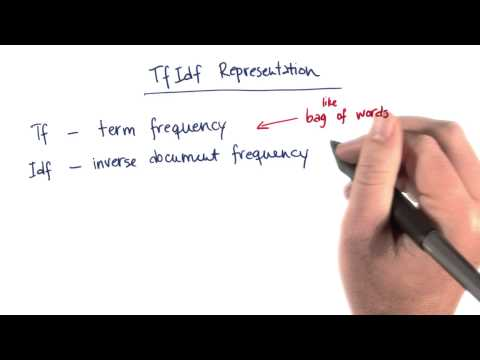

In [11]:
YouTubeVideo("t2Nq3MFK_pg")

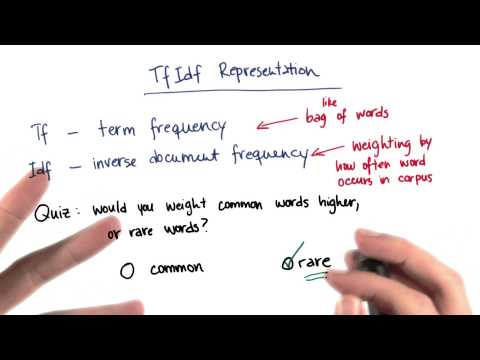

In [12]:
YouTubeVideo("xYQb6f1SIEk")

Para construir essa representação dos textos, vamos utilizar o método [**TfidfVectorizer**](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) do Scikit-Learn. São passados os seguintes parâmetros. Detalhes podem ser encontrados na documentação do método. Explicando alguns: 

* **max_df:** filtra todas as palavras que possuem frequência maior que 80%. Palavras muito frequentes podem não trazer informação, já que é comum em todo o texto. 
* **min_df:** filtra todas as palavras que possuem frequência menor que 20%. Palavras pouco frequentes podem não trazer siginificado nenhum também. 
* **max_features:** máximo de *features* que a matriz deve possuir.
* **stop_words:** elimina *stopwords* em inglês
* **tokenizer:** função de tokenizer utilizada. Neste caso, utilizaremos a função implementada com stemming; 

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(list_of_synopses) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

CPU times: user 2.06 s, sys: 37.8 ms, total: 2.1 s
Wall time: 2.23 s
(100, 92)


A matriz final tem dimensão (100x88), ou seja, 100 textos caracterizados por 88 termos. Observe que isso diminui bastante a dimensionalidade se comparado com todas as palavras do vocabulário (aproximadamente 5000). O vocabulário final pode ser obtido pelo código a seguir:

In [14]:
terms = tfidf_vectorizer.get_feature_names()
print(terms)

['becom', 'befor', 'begin', 'believ', 'boy', 'come', 'complet', 'continu', 'crime', 'day', 'death', 'decid', 'discov', 'doe', 'dure', 'end', 'escap', 'eventu', 'fall', 'famili', 'father', 'film', 'follow', 'forc', 'friend', 'goe', 'good', 'head', 'help', 'home', 'howev', 'includ', 'job', 'kill', 'know', 'known', 'lead', 'learn', 'leav', 'life', 'like', 'littl', 'live', 'look', 'love', 'make', 'man', 'mani', 'meet', 'men', 'mother', 'murder', "n't", 'need', 'new', 'offic', 'old', 'onc', 'onli', 'order', 'peopl', 'person', 'place', 'plan', 'play', 'power', 'realiz', 'return', 'run', 'save', 'sent', 'set', 'small', 'soon', 'start', 'state', 'stori', 'success', 'thing', 'time', 'togeth', 'tri', 'turn', 'use', 'want', 'war', 'way', 'woman', 'work', 'world', 'year', 'young']


A matriz TF-IDF é o objeto de entrada para o K-Means. Cada texto é representado por um conjunto de termos e ele vai utilizar esse conjunto de termos para caracterizar cada instância e calcular a distância entre eles na execução do algoritmo. 

In [15]:
num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

CPU times: user 179 ms, sys: 5.09 ms, total: 184 ms
Wall time: 210 ms


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Modelo treinado, podemos retornar os clusters gerados:

In [16]:
clusters = km.labels_.tolist()
print(len(clusters))

100


**clusters** é uma lista que associa em cada posição um número que representa o cluster. Por exemplo, o documento zero foi classificado no cluster 3.

In [17]:
print(clusters[0])

3


### Visualizando os Clusters

Clusters criados, podemos visualizar os filmes que compõe cada cluster. Vamos criar um dataframe que indexa a lista de filmes e sinopses a partir do cluster que foi associado para cada filme. 

In [18]:
films = { 'title': list_of_titles, 'synopsis': list_of_synopses, 'cluster': clusters}

frame = pd.DataFrame(films, index = [clusters] , columns = ['title', 'synopsis'])

In [19]:
frame.head()

,title,synopsis
3,The Shawshank Redemption,Chronicles the experiences of a formerly succe...
2,The Godfather,When the aging head of a famous crime family d...
2,The Godfather: Part II,The continuing saga of the Corleone crime fami...
1,The Dark Knight,Set within a year after the events of Batman B...
3,12 Angry Men,The defense and the prosecution have rested an...


Uma outra coisa interessante a se fazer é identificar quais são as N palavras mais próximas do centróide de cada cluster. Essa informação pode nos dar uma idéia geral do tipo de filme que compõe cada cluster. Nesse caso, vamos utilizar N = 6.

In [23]:
N = 6

dict_class = {}

print("Top termos por cluster:")
print()

#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Palavras do Cluster %d :" % i, end='')
    list_words = []
    for ind in order_centroids[i, :N]: #replace 6 with n words per cluster
        word = vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore')
        list_words.append(word)
        print(' %s' % word, end=',')
    dict_class[i] = list_words
    print() 
    print() 
    
    print("Filmes do Cluster %d:" % i, end='')
    for title in frame.loc[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print() 
    print() 
    

Top termos por cluster:

Palavras do Cluster 0 : b'kill', b'years', b'officer', b'sent', b'time', b'plan',

Filmes do Cluster 0: Saving Private Ryan, American History X, Terminator 2, Apocalypse Now, Blade Runner 2049, Aliens, Reservoir Dogs, Double Indemnity, 2001: A Space Odyssey, Inglourious Basterds,

Palavras do Cluster 1 : b'war', b'forcing', b'powerful', b'death', b'world', b'new',

Filmes do Cluster 1: The Dark Knight, Schindler's List, The Lord of the Rings: The Return of the King, The Lord of the Rings: The Fellowship of the Ring, Star Wars: Episode V - The Empire Strikes Back, The Lord of the Rings: The Two Towers, Star Wars: Episode IV - A New Hope, Raiders of the Lost Ark, The Pianist, Gladiator, The Great Dictator, Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb, Paths of Glory, The Dark Knight Rises, Star Wars: Episode VI - Return of the Jedi, Lawrence of Arabia, Full Metal Jacket, Dunkirk,

Palavras do Cluster 2 : b'life', b'new', b'live', b'family'

## Usando o DBScan

Vamos realizar a mesma tarefa só que agora utilizando o método DBScan, onde não precisamos passar o número de grupos e ver em quantos grupos os filmes são agrupados. 

In [118]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=1.0, min_samples=2)
%time dbscan.fit(tfidf_matrix)

clusters_dbscan = dbscan.labels_.tolist()
print(len(set(clusters_dbscan)))
print(clusters_dbscan)


CPU times: user 5.96 ms, sys: 3.63 ms, total: 9.59 ms
Wall time: 6.39 ms
9
[0, 1, 1, 1, 0, -1, -1, 2, 3, 4, 5, 4, 1, 3, 2, -1, 0, -1, -1, 5, 0, 0, 0, 4, 1, -1, 1, -1, -1, -1, 1, 1, -1, 0, -1, -1, 4, 4, 5, 1, -1, 0, 0, -1, -1, 5, 4, 1, 0, 0, -1, -1, 4, 2, -1, -1, 6, 2, 7, 3, 1, -1, 4, 1, 0, -1, -1, 0, 7, -1, 4, 1, -1, 0, 5, -1, 0, 0, 0, 4, -1, -1, 6, -1, 0, -1, -1, 4, -1, -1, 2, -1, -1, 1, 1, 3, -1, 3, 0, -1]


In [119]:
films_dbscan = { 'title': list_of_titles, 'synopsis': list_of_synopses, 'cluster': clusters_dbscan}

frame_dbscan = pd.DataFrame(films_dbscan, index = [clusters_dbscan] , columns = ['title', 'synopsis'])

In [121]:
print("Top termos por cluster:")
print()

num_clusters = len(set(clusters_dbscan)) - 1 #desconsidera os clusters -1
print(num_clusters)

for i in range(num_clusters):
    print("Filmes do Cluster %d:" % i, end='')
    for title in frame_dbscan.loc[i]['title'].values.tolist():
        #print(frame_dbscan.loc[i])
        print(' %s,' % title, end='')
    print() 
    print() 

Top termos por cluster:

8
Filmes do Cluster 0: The Shawshank Redemption, 12 Angry Men, Goodfellas, City of God, Se7en, The Silence of the Lambs, The Green Mile, Rear Window, Terminator 2, Memento, Apocalypse Now, Princess Mononoke, Witness for the Prosecution, North by Northwest, Reservoir Dogs, M, Requiem for a Dream, Double Indemnity, Inglourious Basterds,

Filmes do Cluster 1: The Godfather, The Godfather: Part II, The Dark Knight, Star Wars: Episode V - The Empire Strikes Back, Life Is Beautiful, Léon: The Professional, Once Upon a Time in the West, Interstellar, The Pianist, The Lion King, The Shining, The Dark Knight Rises, Dangal, Toy Story 3, Toy Story,

Filmes do Cluster 2: The Lord of the Rings: The Return of the King, The Lord of the Rings: The Two Towers, Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb, Paths of Glory, Dunkirk,

Filmes do Cluster 3: The Good, the Bad and the Ugly, Inception, Django Unchained, The Sting, Bicycle Thieves,

Filmes do Clus

## Classificando novos documentos

Podemos utilizar a classificação gerada para classificar novos documentos. Ou seja, utilizaríamos 5 classes e usaríamos esta classificação como nossa base de treinamento e então poderíamos utilizar este modelo para classificar novos filmes. Essa tarefa é proposta em outro exercício. Para isso, vamos gerar a nossa base de treinamento e armazenar em um arquivo que será utilizado na outra tarefa. 

In [122]:
data_classified = []

count = 0

for imdbid in list_of_ids:
    data_classified.append({'imdbid': imdbid, 'class': clusters[count], 'title': list_of_titles[count], 'sinopsis': list_of_synopses[count]})
    count += 1

In [123]:
joblib.dump(data_classified, "moviesclassifieds.pkl")

['moviesclassifieds.pkl']

Para facilitar a identificação dos Clusters vamos salvar também um dicionário com a identificação de clada cluster. Estamos utilizando a classificação gerada pelo KMeans. 

In [124]:
joblib.dump(dict_class, "moviesclass.pkl")

['moviesclass.pkl']